In [6]:
import pandas as pd
import geopandas as gp
import numpy as np
import rasterio as rio
import xarray
import rioxarray
import matplotlib.pyplot as plt

In [7]:
xds = xarray.open_dataset("data/FF_201212_CF.nc")

In [8]:
xds_filtered = xds.where(xds.time == np.unique(xds.time)[0], drop = True)

(3850000.0, 3950000.0, 2350000.0, 2550000.0)

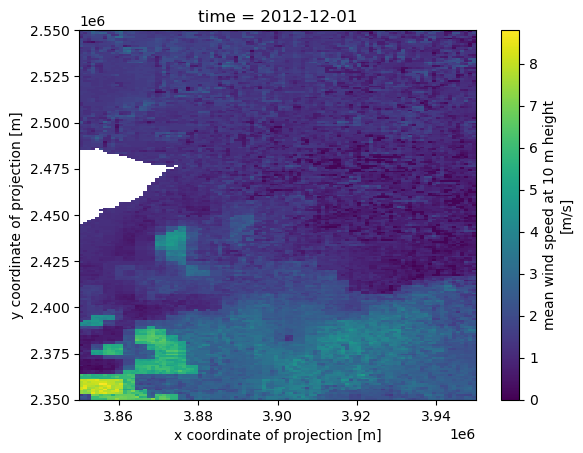

In [291]:
xds_filtered.FF.plot()
#plt.axis([x * 1e6 for x in [3.8, 4.0, 2.3, 2.6]])
plt.axis([x * 1e6 for x in [3.85, 3.95, 2.35, 2.55]])

In [110]:
import pyrosm as psm
import geopandas as gpd
import shapely

In [21]:
# Initialize the OSM parser object with test data from Helsinki
osm = psm.OSM("data/tuebingen-regbez-latest.osm.pbf")

In [102]:
# Filter for power lines
# https://pyrosm.readthedocs.io/en/latest/custom_filter.html
# https://wiki.openstreetmap.org/wiki/Map_features#Power
power = ["line"] #, "minor_line", "cable"
grid = osm.get_data_by_custom_criteria(custom_filter={"power": power},
                                        # Keep data matching the criteria above
                                        filter_type="keep",
                                        # Do not keep nodes (point data)    
                                        keep_nodes=False, 
                                        keep_ways=True, 
                                        keep_relations=True)

In [103]:
states = gpd.read_file("data/gadm41_DEU_shp/gadm41_DEU_1.shp")

(9.0, 9.5, 47.75, 48.0)

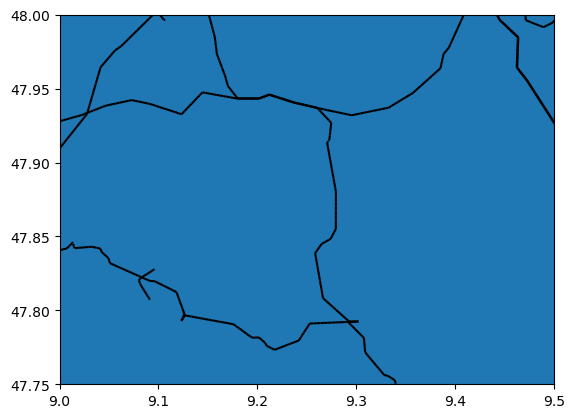

In [258]:
fig, ax = plt.subplots(1, 1)
states.plot(ax = ax)
grid.plot(ax = ax, color = "black")
#plt.axis([8.5, 10.5, 47, 49])
plt.axis([9.0, 9.5, 47.75, 48])

In [127]:
grid = grid.explode("geometry").reset_index()

/var/folders/56/097r5m_53z97wd0wwmqws76m0000gn/T/ipykernel_25209/805880078.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  grid = grid.explode("geometry").reset_index()


In [ ]:
import networkx as nx
import momepy

In [ ]:
# https://networkx.org/documentation/latest/auto_examples/geospatial/fix_plot_lines.html#sphx-glr-auto-examples-geospatial-fix-plot-lines-py
geo_graph = momepy.gdf_to_nx(grid, approach = "dual")

/usr/local/anaconda3/envs/geospatial/lib/python3.10/site-packages/momepy/utils.py:247: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length
/usr/local/anaconda3/envs/geospatial/lib/python3.10/site-packages/momepy/utils.py:98: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cent = gdf_network.geometry.centroid


(47.9, 48.0)

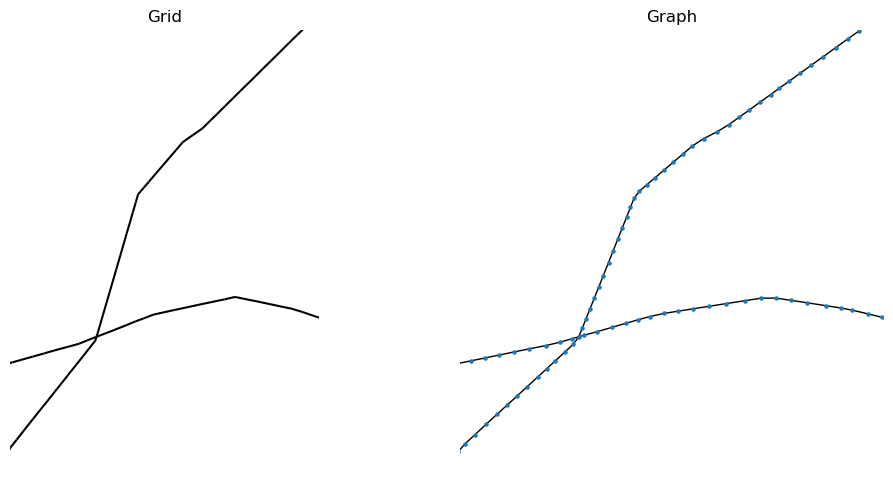

In [ ]:
positions = {n: [n[0], n[1]] for n in list(geo_graph.nodes)}

# Plot
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
grid.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Grid", "Graph")[i])
    facet.axis("off")
nx.draw(geo_graph, positions, ax=ax[1], node_size=5)
ax[0].set_xlim([9.0, 9.1])
ax[0].set_ylim([47.9, 48])

In [ ]:
centrality = nx.closeness_centrality(geo_graph)

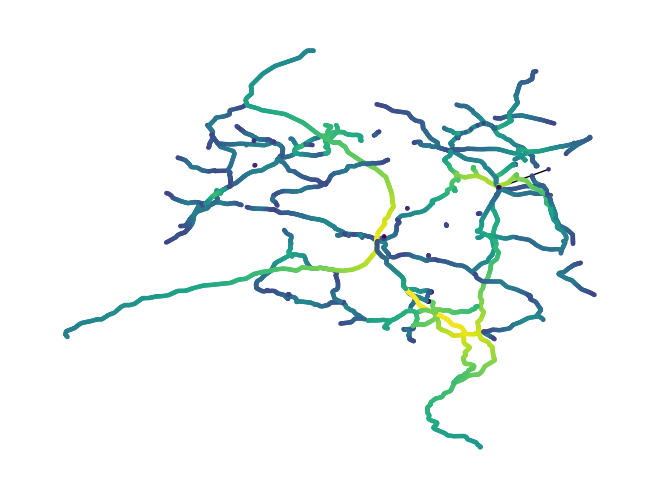

In [ ]:
nx.draw(geo_graph, positions, node_color = list(centrality.values()), node_size=5)

In [181]:
from tqdm import tqdm

out = [None] * len(grid)
for i in tqdm(range(len(grid))):
    f.value += 1
    tmp = [grid.loc[i, "geometry"].intersects(x) for x in grid.loc[:, "geometry"]]
    out[i] = [i for i, x in enumerate(tmp) if x]

In [189]:
import json
with open("data/grid_intersects.json", "w") as file:
    file.write(json.dumps(out))

In [195]:
for i in range(len(out)):
    out[i].remove(i)

<AxesSubplot: >

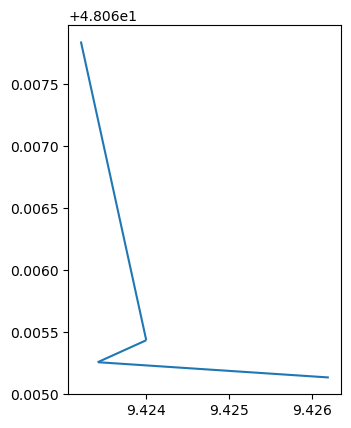

In [237]:
subgrid = grid.loc[out[0],:]
subgrid.plot()

/usr/local/anaconda3/envs/geospatial/lib/python3.10/site-packages/momepy/utils.py:247: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


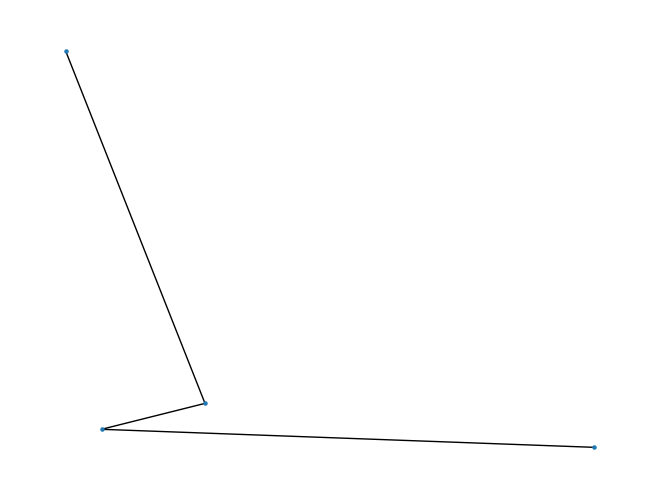

In [229]:
geo_graph = momepy.gdf_to_nx(subgrid)
positions = {n: [n[0], n[1]] for n in list(geo_graph.nodes)}
nx.draw(geo_graph, positions, node_size=5)

In [257]:
shapely.ops.split(subgrid["geometry"].iloc[1], subgrid["geometry"].iloc[0]).geoms[1]


IndexError: index out of range

{'whiskers': [<matplotlib.lines.Line2D at 0x3d813dcf0>,
 'caps': [<matplotlib.lines.Line2D at 0x3d813e230>,
 'boxes': [<matplotlib.lines.Line2D at 0x3d813da50>],
 'medians': [<matplotlib.lines.Line2D at 0x3d813e770>],
 'fliers': [<matplotlib.lines.Line2D at 0x3d813ea10>],
 'means': []}

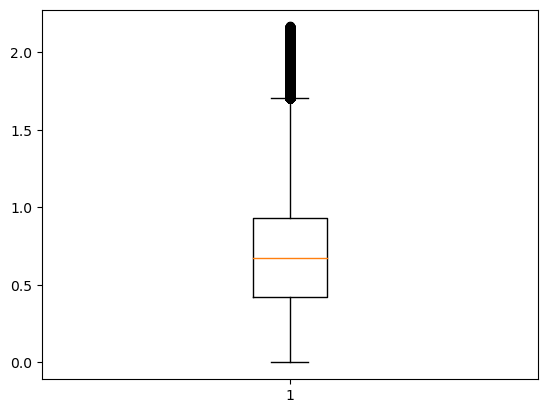

In [289]:
import scipy.spatial.distance
plt.boxplot(scipy.spatial.distance.pdist(geo_graph.nodes, "euclidean"))

In [151]:
for i in range(len(grid["geometry"][0:1])):
    shapely.ops.split(grid.loc[i, "geometry"], 
                      grid.loc[np.bitwise_not(grid.index==i), "geometry"])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
"started": "2022-10-18T13:08:01.977096Z", "pending": null, "ready": true, "url": "/jhub/user/tu_zxobe27/", "user_options": {"nprocs": ["1"], "gpu": ["0"], "runtime": ["0:30:00"], "partition": ["single"], "memory": ["4G"], "basemoduleselect": ["jupyter/tensorflow"], "basemodule": ["jupyter/tensorflow"], "autoreservationstring": ["true"], "expertmodestring": ["false"], "reservation": [""], "reservationstring": ["#SBATCH --reservation=juypter_weekday_cpuonly"], "groupname": [""], "groupnamestring": [""], "lsdfstring": [""], "beeondstring": [""], "containermodestring": ["false"], "containermodedeactivate": [""], "containermodeactivate": ["#"], "containerimage": [""], "containerimagestring": [""], "containername": [""], "containernameifvoid": ["1666084949323"], "containernamestring": [""], "enrootmounthomestring": [""], "enrootdefaultmountstring": [""], "enrootremaprootstring": [""]}, "progress_url": "/jhub/hub/api/users/tu_zxobe27/server/progress"}}}

In [50]:
import requests

user = "tu_zxobe27"
token = 

b'{"name": "tu_zxobe27", "created": "2022-06-28T18:42:40.993052Z", "server": "/jhub/user/tu_zxobe27/", "groups": [], "last_activity": "2022-10-18T13:08:26.100618Z", "kind": "user", "admin": false, "pending": null, "roles": ["user"], "servers": {"": {"name": "", "last_activity": "2022-10-18T13:08:26.100618Z", "started": "2022-10-18T13:08:01.977096Z", "pending": null, "ready": true, "url": "/jhub/user/tu_zxobe27/", "user_options": {"nprocs": ["1"], "gpu": ["0"], "runtime": ["0:30:00"], "partition": ["single"], "memory": ["4G"], "basemoduleselect": ["jupyter/tensorflow"], "basemodule": ["jupyter/tensorflow"], "autoreservationstring": ["true"], "expertmodestring": ["false"], "reservation": [""], "reservationstring": ["#SBATCH --reservation=juypter_weekday_cpuonly"], "groupname": [""], "groupnamestring": [""], "lsdfstring": [""], "beeondstring": [""], "containermodestring": ["false"], "containermodedeactivate": [""], "containermodeactivate": ["#"], "containerimage": [""], "containerimagestr

In [2]:
import modules.jupyter_environment
env = modules.jupyter_environment.jupyter_environment("tu_zxobe27", "c6bb5fc4375b4b41a4c87e7310b4b17c")

In [8]:
env.get_status()

{'name': 'tu_zxobe27',
 'created': '2022-06-28T18:42:40.993052Z',
 'server': '/jhub/user/tu_zxobe27/',
 'groups': [],
 'last_activity': '2022-10-18T15:35:08.114620Z',
 'kind': 'user',
 'admin': False,
 'pending': None,
 'roles': ['user'],
 'servers': {'': {'name': '',
   'last_activity': '2022-10-18T15:35:08.114620Z',
   'started': '2022-10-18T15:33:59.077352Z',
   'pending': None,
   'ready': True,
   'url': '/jhub/user/tu_zxobe27/',
   'user_options': {'nprocs': ['1'],
    'gpu': ['0'],
    'runtime': ['0:30:00'],
    'partition': ['single'],
    'memory': ['4G'],
    'basemoduleselect': ['jupyter/tensorflow'],
    'basemodule': ['jupyter/tensorflow'],
    'autoreservationstring': ['true'],
    'expertmodestring': ['false'],
    'reservation': [''],
    'reservationstring': ['#SBATCH --reservation=juypter_weekday_cpuonly'],
    'groupname': [''],
    'groupnamestring': [''],
    'lsdfstring': [''],
    'beeondstring': [''],
    'containermodestring': ['false'],
    'containermodedeac

In [5]:
env.start_server()

True

In [3]:
env.stop_server()

True

In [23]:
from owslib.wfs import WebFeatureService

In [24]:
wfs = WebFeatureService(url='https://isk.geobasis-bb.de/ows/aktualitaeten_wfs?', version='1.1.0')

In [26]:
wfs.identification.title

'WFS BB Aktualitäten-LGB'

In [27]:
[operation.name for operation in wfs.operations]

['DescribeFeatureType', 'GetCapabilities', 'GetFeature', 'GetGmlObject']

In [50]:
response = wfs.getfeature(typename='app:dop20rgbi_2016_2018_single', 
                          bbox=bbox, 
                          srsname='EPSG:25833')

In [81]:
soup.find("app:creationdate").text

'2017-06-02'

In [13]:
list(wms.contents)

['dop20_bebb_2016_2018_farbe', 'dop20_bebb_2016_2018_graustufen']

In [22]:
wms.contents["dop20_bebb_2016_2018_farbe"].timepositions

In [ ]:
wms.

In [17]:
[op.name for op in wms.operations]

['GetCapabilities', 'GetMap', 'GetFeatureInfo']

In [19]:
wms.getOperationByName('GetMap').formatOptions

['image/jpeg', 'image/png', 'image/gif']

In [3]:
bbox = (394168.38, 5796138.69, 394388.69, 5796390.61)

In [1]:
from owslib.wms import WebMapService

In [2]:
wms = WebMapService('https://isk.geobasis-bb.de/mapproxy/dop20_2016_2018/service/wms?', version='1.1.1')

In [ ]:
wms.identification.title
wms.identification.abstract

'Dieser Web Map Service stellt digitale farbige und graue Orthophotos (Luftbilder) mit der Bodenauflösung von 20cm vom Gebiet Brandenburg (2016-2018)/Berlin (2017) zur Verfügung.'

In [4]:
img = wms.getmap(layers = ["dop20_bebb_2016_2018_farbe"],
                srs = "EPSG:25833",
                size = [((bbox[2] - bbox[0]) / .2), 
                ((bbox[3] - bbox[1]) / .2)],
                bbox = bbox,
                format = "image/jpeg").read()

In [6]:
import numpy as np
from PIL import Image

In [7]:
from io import BytesIO
from datetime import datetime

In [10]:
import xarray

In [8]:
tmp = np.asarray(Image.open(BytesIO(img)))

In [ ]:
.rio.to_raster(raster_path="/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/test.tif", driver="COG")

In [32]:
tmp

array([[[ 27,  37,  36],
        [ 22,  32,  31],
        [ 26,  36,  35],
        ...,
        [217, 219, 218],
        [215, 217, 216],
        [205, 207, 206]],

       [[ 27,  37,  36],
        [ 23,  33,  32],
        [ 27,  37,  36],
        ...,
        [205, 207, 206],
        [194, 196, 195],
        [187, 189, 188]],

       [[ 23,  33,  32],
        [ 26,  36,  35],
        [ 38,  48,  47],
        ...,
        [160, 162, 161],
        [147, 149, 148],
        [145, 147, 146]],

       ...,

       [[153, 149, 137],
        [159, 156, 141],
        [160, 157, 142],
        ...,
        [141, 137, 136],
        [140, 136, 135],
        [140, 136, 135]],

       [[147, 144, 129],
        [156, 153, 136],
        [157, 154, 137],
        ...,
        [140, 136, 135],
        [139, 135, 134],
        [138, 134, 133]],

       [[143, 137, 121],
        [156, 151, 132],
        [159, 154, 135],
        ...,
        [138, 134, 133],
        [137, 133, 132],
        [137, 133, 130]]

In [31]:
tmp[:,:,0]

array([[ 27,  22,  26, ..., 217, 215, 205],
       [ 27,  23,  27, ..., 205, 194, 187],
       [ 23,  26,  38, ..., 160, 147, 145],
       ...,
       [153, 159, 160, ..., 141, 140, 140],
       [147, 156, 157, ..., 140, 139, 138],
       [143, 156, 159, ..., 138, 137, 137]], dtype=uint8)

In [28]:
tmp_xd = xarray.Dataset(data_vars = {"red": (["x", "y"], tmp[:,:,0]),
                            "green": (["x", "y"], tmp[:,:,1]),
                            "blue": (["x", "y"], tmp[:,:,2])},
                 coords = {"x": (["x"], np.arange(tmp.shape[0]) * .2 + bbox[0]),
                           "y": (["y"], np.arange(tmp.shape[1]) * .2 + bbox[2])})

In [33]:
tmp_xd = tmp_xd.astype("int")

In [34]:
tmp_xd

<xarray.Dataset>
Dimensions:      (x: 1259, y: 1101)
Coordinates:
  * x            (x) float64 3.942e+05 3.942e+05 ... 3.944e+05 3.944e+05
  * y            (y) float64 3.944e+05 3.944e+05 ... 3.946e+05 3.946e+05
    spatial_ref  int64 0
Data variables:
    red          (x, y) int64 27 22 26 39 48 47 45 ... 135 135 137 138 137 137
    green        (x, y) int64 37 32 36 49 58 58 57 ... 131 131 133 134 133 133
    blue         (x, y) int64 36 31 35 48 57 54 53 ... 130 130 132 133 132 130

In [30]:
tmp_xd.rio.write_crs(25833, inplace = True)

<xarray.Dataset>
Dimensions:      (x: 1259, y: 1101)
Coordinates:
  * x            (x) float64 3.942e+05 3.942e+05 ... 3.944e+05 3.944e+05
  * y            (y) float64 3.944e+05 3.944e+05 ... 3.946e+05 3.946e+05
    spatial_ref  int64 0
Data variables:
    red          (x, y) uint8 27 22 26 39 48 47 45 ... 135 135 137 138 137 137
    green        (x, y) uint8 37 32 36 49 58 58 57 ... 131 131 133 134 133 133
    blue         (x, y) uint8 36 31 35 48 57 54 53 ... 130 130 132 133 132 130

In [55]:
tmp_xa = rioxarray.open_rasterio(BytesIO(img))

/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/conda/envs/ds_project/lib/python3.10/site-packages/rioxarray/_io.py:924: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [20]:
timestamp = datetime.strptime('2017-06-02', "%Y-%m-%d")

In [56]:
tmp_xa = tmp_xa.expand_dims(dim = {"time": 1})

In [59]:
tmp_xa = tmp_xa.assign_coords(x = (tmp_xa.x - .5) * .2 + bbox[0],
                              y = (tmp_xa.y - .5) * .2 + bbox[2],
                              time = [timestamp])

In [68]:
tmp_xa.where(tmp_xa.band == 0, drop = True)

<xarray.DataArray (time: 1, band: 0, y: 1259, x: 1101)>
array([], shape=(1, 0, 1259, 1101), dtype=float64)
Coordinates:
  * band         (band) int64 
  * x            (x) float64 3.942e+05 3.942e+05 ... 3.944e+05 3.944e+05
  * y            (y) float64 3.944e+05 3.944e+05 ... 3.946e+05 3.946e+05
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2017-06-02
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [1]:
import xarray

In [2]:
import rioxarray

In [3]:
test = xarray.open_dataset("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/brandenburg_394168.38_5796138.69_394388.69_5796390.61.nc", engine="rasterio")

In [4]:
test

<xarray.Dataset>
Dimensions:      (band: 1, x: 1101, y: 1259)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.796e+06 5.796e+06 ... 5.796e+06 5.796e+06
  * y            (y) float64 3.944e+05 3.944e+05 ... 3.942e+05 3.942e+05
    spatial_ref  int64 ...
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...

In [35]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [32]:
img_jpg = img.read()

In [39]:
with open("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/test.jpg", "wb") as file:
    file.write(img_jpg)

In [40]:
import matplotlib.image as mpimg
jpg = mpimg.imread("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/test.jpg")
plt.imshow(jpg)

In [1]:
import geopandas as gpd
import pandas as pd
from geocube.api.core import make_geocube
import numpy as np
import xarray

In [2]:
storage_directory = "/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/borders"
crs = 25833

In [2]:
import fiona
fiona.supported_drivers["NAS"] = "raw"

In [3]:
shapes = gpd.read_file(f"/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/orthography/raw/BDA_41010.xml").to_crs("EPSG:25833")
shapes["settlement"] = 1

In [8]:
borders = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/borders/gadm41_DEU_0.json")

In [19]:
test = make_geocube(shapes, measurements = ["settlement"], resolution = (-1e3, 1e3), fill = 0)

In [21]:
test

<xarray.Dataset>
Dimensions:      (y: 859, x: 641)
Coordinates:
  * y            (y) float64 6.118e+06 6.116e+06 6.116e+06 ... 5.26e+06 5.26e+06
  * x            (x) float64 -1.385e+05 -1.375e+05 ... 5.005e+05 5.015e+05
    spatial_ref  int64 0
Data variables:
    settlement   (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

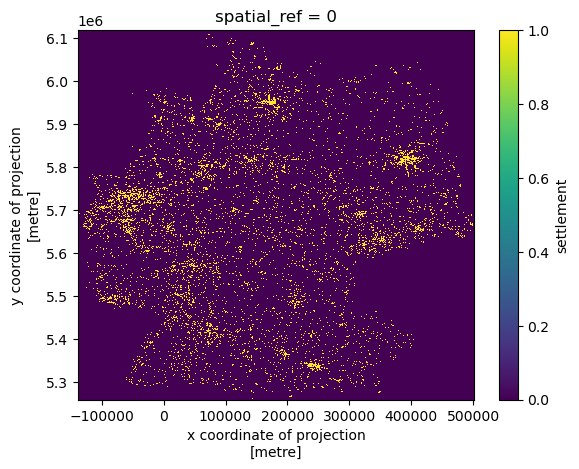

In [20]:
test["settlement"].plot()

In [12]:
test.plot()

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

In [23]:
test

In [7]:
borders

GID_0  COUNTRY                                           geometry
0   DEU  Germany  MULTIPOLYGON (((-27542.666 5290781.687, -29753...

In [44]:
shape = shapes.iloc[[shapes.area.sort_values(ascending = False).index[0]], :]

<AxesSubplot: >

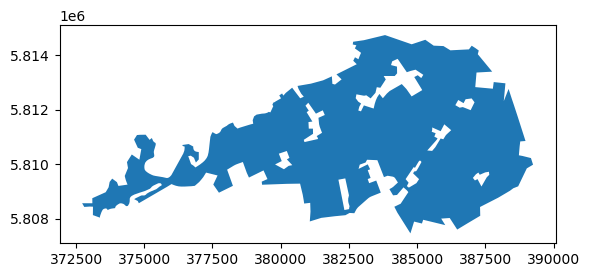

In [45]:
shape.plot()

In [46]:
clipped = borders.overlay(shape, how = "difference")

<AxesSubplot: >

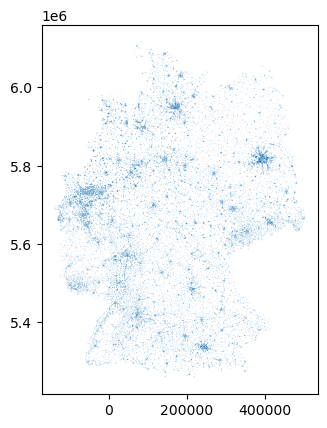

In [26]:
shapes.plot()

<AxesSubplot: >

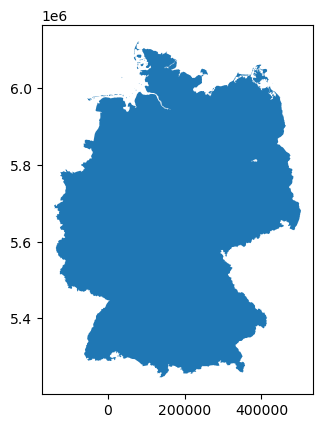

In [47]:
clipped.plot()

In [107]:
bounds = borders.total_bounds
n_tiles = 10
tiles = [[[bounds[0] + (i) * (bounds[2] - bounds[0]) / n_tiles,
   bounds[1] + (j) * (bounds[3] - bounds[1]) / n_tiles,
   bounds[0] + (i + 1) * (bounds[2] - bounds[0]) / n_tiles,
   bounds[1] + (j + 1) * (bounds[3] - bounds[1]) / n_tiles] for i in range(n_tiles)] for j in range(n_tiles)]

In [159]:
flattened = np.array(out).flatten()

/scratch/slurm_tmpdir/job_21164191/ipykernel_665550/838192428.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flattened = np.array(out).flatten()


In [170]:
gpd.GeoDataFrame(pd.concat(flattened))["geometry"].unary_union

<AxesSubplot: >

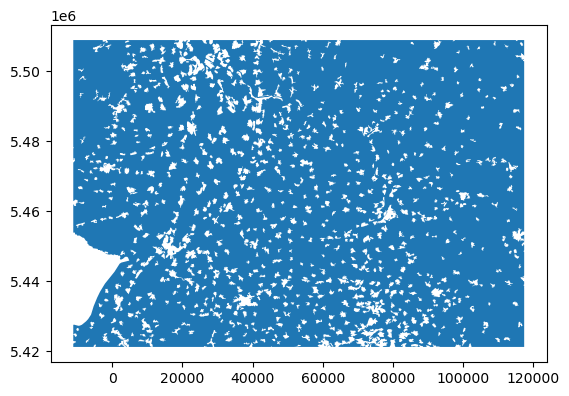

In [151]:
out[0][2]["geometry"].union(out[0][3]["geometry"]).plot()

In [148]:
gpd.union(, )

AttributeError: module 'geopandas' has no attribute 'union'

GID_0  COUNTRY                                           geometry
0   DEU  Germany  MULTIPOLYGON (((53136.715 5499028.896, 53136.7...

In [142]:
out = [[None] * n_tiles] * n_tiles
for i in range(n_tiles):
    for j in range(n_tiles):
        wtile = borders.clip(tiles[i][j])
        if wtile.shape[0] != 0:
            out[i][j] = wtile.overlay(shapes[shapes.intersects(wtile["geometry"][0])], how = "difference")

/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/conda/envs/ds_project/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/conda/envs/ds_project/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/conda/envs/ds_project/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, 

KeyboardInterrupt: 

In [125]:
test = tmp.overlay(shapes[shapes.intersects(tmp["geometry"][0])], how = "difference")

<AxesSubplot: >

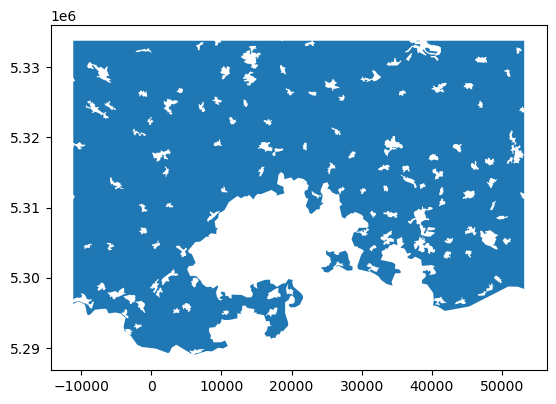

In [126]:
test.plot()